In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

Using TensorFlow backend.
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\sit

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)


Loading model successfully...


In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 196 images...


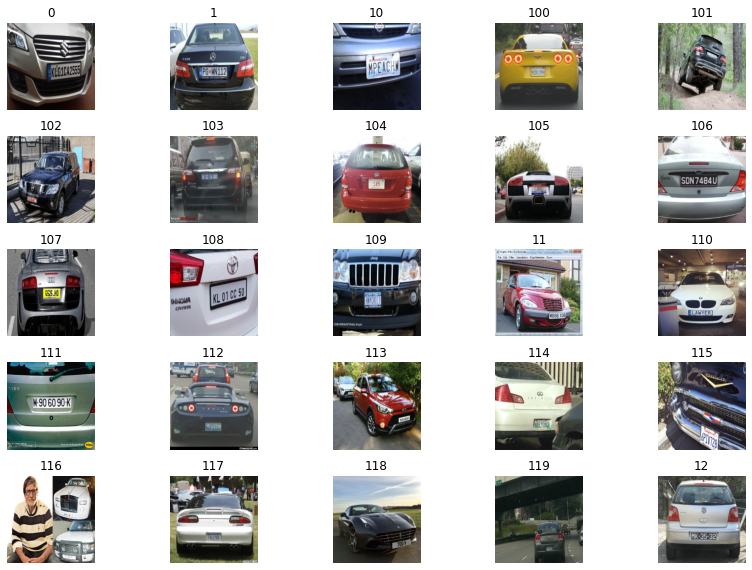

In [5]:
# Create a list of image paths 
image_paths = glob.glob("dataset/images/*.png")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()


If there is no plate founded, the program would warn you with an error “No License plate is founded!”. In this case, try to increase Dmin value to adjust the boundary dimension. It should be mentioned that Wpod-Net is able to detect only standard plates(black character, white background), and if the image is too blurry or the plate is hidden by obstacles, the model might fail to predict it.


Detect 2 plate(s) in 0
Coordinate of plate(s) in image: 
 [array([[301.02856953, 417.98741605, 418.00574537, 301.04689885],
       [125.22687977, 123.84731724, 167.5846394 , 168.96420193],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[315.74689656, 341.40424044, 349.21022289, 323.552879  ],
       [ 66.51200118,  74.6238934 ,  90.17104251,  82.05915029],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


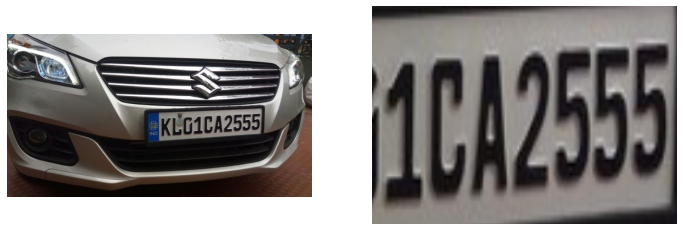

In [7]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    # print("Height {}, Width {}".format(vehicle.shape[0], vehicle.shape[1]) )
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
image_paths = glob.glob("dataset/images/*.png")
test_image = image_paths[0]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

# Get xy coordinate

In [42]:
cor

[array([[213.32673572, 284.07075668, 271.20170881, 200.45768785],
        [104.38050602, 116.3709671 , 170.07482674, 158.08436565],
        [  1.        ,   1.        ,   1.        ,   1.        ]])]

In [43]:
# x coordinate
X = cor[0][0]

In [44]:
# y coordinate
Y = cor[0][1]

In [21]:
def get_XY_coor(X_list, Y_list):
    coor = []
    for i in range(4):
        x = X_list[i]
        y = Y_list[i]
        coor.append([x,y])
    return coor

In [45]:
coor_predict = get_XY_coor(X, Y)

In [46]:
coor_predict

[[213.32673572209444, 104.38050601597112],
 [284.0707566828985, 116.37096710135249],
 [271.20170881494425, 170.0748267358317],
 [200.45768785414023, 158.08436565045034]]

In [57]:
coor_label = [[43, 22],
 [110, 14],
 [112, 34],
 [45, 42]]

In [55]:
coor_label

[[43.49545080214739, 22.703327596304465],
 [110.89926394419027, 14.921639641944099],
 [112.940327436305, 34.78009937826325],
 [45.53651429426211, 42.56178733262361]]

# Examine IOU

<img src="https://blog.paperspace.com/content/images/2020/09/Fig06-1.jpg" alt="IOU" title="IOU" style="width:50%; height:auto" />

In [59]:
from shapely.geometry import box, Polygon
def IOU(pol1_xy, pol2_xy):
    # Define each polygon
    polygon1_shape = Polygon(pol1_xy)
    polygon2_shape = Polygon(pol2_xy)

    # intersection
    polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
    
    # union = shape1 + shape2 - union
    polygon_union = polygon1_shape.area + polygon2_shape.area - polygon_intersection
    
    # IOU = intersection / union
    return polygon_intersection / polygon_union

In [60]:
pol1_xy = [[130, 27], [129.52, 27], [129.45, 27.1], [130.13, 26]]
pol2_xy = [[30, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
IOU(coor_label, coor_predict)

0.904761826987518

# AP

<img src="https://blog.paperspace.com/content/images/2020/09/Fig04-1.jpg" alt="Average Precision" title="Average Precision" style="scale:0.5"/>

In [69]:
def calculate_AP(preList, recList):
    preList.append(1)
    recList.append(0)
    precisions = np.array(preList)
    recalls = np.array(recList)
    ap = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
        
    return ap
    

In [19]:
import sklearn.metrics
def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls


In [ ]:
y_true = ["positive", "negative", "negative", "positive", "positive", "positive", "negative", "positive", "negative", "positive", "positive", "positive", "positive", "negative", "negative", "negative"]
pred_scores = [0.7, 0.3, 0.5, 0.6, 0.55, 0.9, 0.4, 0.2, 0.4, 0.3, 0.7, 0.5, 0.8, 0.2, 0.3, 0.35]
thresholds=np.arange(start=0.2, stop=0.7, step=0.05)

precisions, recalls = precision_recall_curve(y_true=y_true, 
                                             pred_scores=pred_scores, 
                                             thresholds=thresholds)
plt.plot(precisions, recalls)
APlist = []
APlist.append(calculate_AP(precisions, recalls))
print(APlist)


# mAP

<img src="https://blog.paperspace.com/content/images/2020/09/Fig13-1.jpg" alt="Mean Average Precision" title="Mean Average Precision" style="scale=0.3" />

In [73]:
def calculate_mAP(APlist):
    return np.sum(APlist)/len(APlist)

**because in here we just having one class so $mAP == AP$**

In [76]:
calculate_mAP(APlist)

0.8898809523809523

# Drawing bounding box

In [16]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the bottom-left, bottom-right, top-right, top-left
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


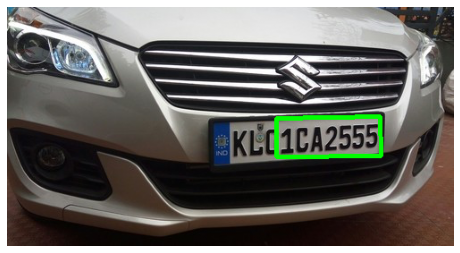

In [17]:
plt.figure(figsize=(8,8))
plt.axis(False)
image_paths = glob.glob("dataset/images/*.png")
test_image = image_paths[0]
plt.imshow(draw_box(test_image,cor))

Found 196 images...


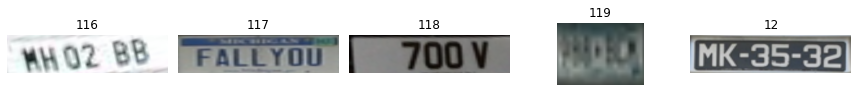

In [15]:
# Create a list of image paths 
image_paths = glob.glob("dataset/images/*.png")
print("Found %i images..."%(len(image_paths)))

# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 5
fig_list = []

for i in range(5*(rows-1), rows*cols):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_paths[i], Dmin=300)
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

Detect 2 plate(s) in 0
Coordinate of plate(s) in image: 
 [array([[301.02856953, 417.98741605, 418.00574537, 301.04689885],
       [125.22687977, 123.84731724, 167.5846394 , 168.96420193],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[315.74689656, 341.40424044, 349.21022289, 323.552879  ],
       [ 66.51200118,  74.6238934 ,  90.17104251,  82.05915029],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


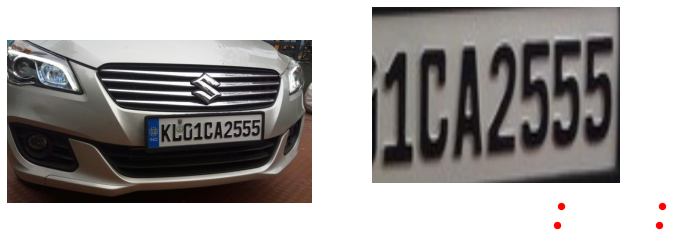

In [12]:
# Obtain plate image and its coordinates from an image
image_paths = glob.glob("dataset/images/*.png")
test_image = image_paths[0]
LpImg,cor = get_plate(test_image, Dmin=300)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])
plt.scatter(x=[213.25465632, 328.08324815, 323.94959702, 209.12100519], y=[225.44029535, 225.16117293, 246.48286214, 246.76198455], c='r', s=40)

# plt.savefig("part1_result.jpg",dpi=300)

## Extract multiple plate in one image

Detect 2 plate(s) in multiple_plates


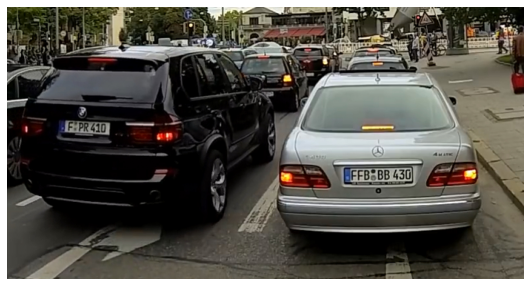

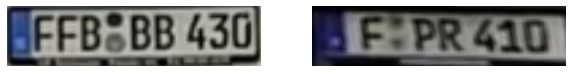

In [355]:
# Extract mutiple plate license in one image 

multiple_plates_image = "Plate_examples/multiple_plates.png"
LpImg,cor = get_plate(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
for i in range(len(LpImg)):
    plt.subplot(1,len(LpImg),i+1)
    plt.axis(False)
    plt.imshow(LpImg[i])


